In [9]:
pip install --upgrade pip


  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install lightgbm 


     ---------------------------------------- 1.0/1.0 MB 542.0 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install xgboost


     ------------------------------------ 125.4/125.4 MB 370.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install catboost


     ---------------------------------------- 73.9/73.9 MB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 15.2/15.2 MB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')


In [3]:
train_root_path = 'C:/Users/ayush/Desktop/projects/Transaction Value of Bank Customer/train.csv.zip'
test_root_path = 'C:/Users/ayush/Desktop/projects/Transaction Value of Bank Customer/test.csv.zip'

train_df = pd.read_csv(train_root_path)
test_df = pd.read_csv(test_root_path)

train_df.head()




,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [23]:
print(train_df.shape)
print(test_df.shape)

(4459, 4993)
(49342, 4992)


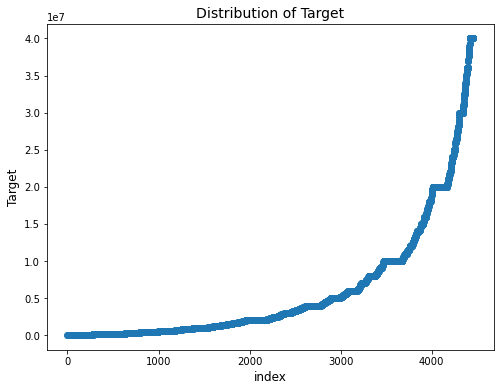

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title('Distribution of Target', fontsize=14)
plt.show()

In [25]:
print("All Features in Train data with NaN Values =", str(train_df.columns[train_df.isnull().sum() != 0].size) )

All Features in Train data with NaN Values = 0


In [27]:
const_columns_to_remove = []
for col in train_df.columns:
    if col != 'ID' and col != 'target':
        if train_df[col].std() == 0:
            const_columns_to_remove.append(col)
            
            
            

# Now remove that array of const columns from the data
train_df.drop(const_columns_to_remove, axis=1, inplace=True)
test_df.drop(const_columns_to_remove, axis=1, inplace=True)

# Print to see the reduction of columns
print('train_df rows and columns after removing constant columns: ', train_df.shape)

print('Following `{}` Constant Column\n are removed'.format(len(const_columns_to_remove)))
print(const_columns_to_remove)



train_df rows and columns after removing constant columns:  (4459, 4737)
Following `256` Constant Column
 are removed
['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e

In [28]:
train_df = train_df.loc[:,~train_df.columns.duplicated()]
print('Train rows and columns after removing duplicate columns: ', train_df.shape)

Train rows and columns after removing duplicate columns:  (4459, 4737)


In [35]:
def drop_sparse_from_train_test(train, test):
    column_list_to_drop_data_from = [x for x in train.columns if not x in ['ID','target']]
    for f in column_list_to_drop_data_from:
        if len(np.unique(train[f]))<2:
            train.drop(f, axis=1, inplace=True)
            test.drop(f, axis=1, inplace=True)
    return train, test

train_df, test_df = drop_sparse_from_train_test(train_df, test_df)

In [36]:
X_train = train_df.drop(['ID', 'target'], axis=1)

y_train = np.log1p(train_df['target'].values)

X_test_original = test_df.drop('ID', axis=1)

X_train_split, X_validation, y_train_split, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [38]:
def light_gbm_model_run(train_x, train_y, validation_x, validation_y, test_x):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 100,
        "learning_rate" : 0.001,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    # Given its a regression case, I am using the RMSE as the metric.

    lg_train = lgb.Dataset(train_x, label=train_y)
    lg_validation = lgb.Dataset(validation_x, label=validation_y)
    evals_result_lgbm = {}

    model_light_gbm = lgb.train(params, lg_train, 5000,
                      valid_sets=[lg_train, lg_validation],
                      early_stopping_rounds=100,
                      verbose_eval=150,
                      evals_result=evals_result_lgbm )

    pred_test_light_gbm = np.expm1(model_light_gbm.predict(test_x, num_iteration=model_light_gbm.best_iteration ))

    return pred_test_light_gbm, model_light_gbm, evals_result_lgbm


In [39]:
predictions_test_y_light_gbm, model_lgbm, evals_result = light_gbm_model_run(X_train_split, y_train_split, X_validation, y_validation, X_test_original)
print('Output of LightGBM Model training..')

[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds
[150]	training's rmse: 1.66447	valid_1's rmse: 1.63998
[300]	training's rmse: 1.57647	valid_1's rmse: 1.59273
[450]	training's rmse: 1.49838	valid_1's rmse: 1.55444
[600]	training's rmse: 1.42899	valid_1's rmse: 1.5229
[750]	training's rmse: 1.36605	valid_1's rmse: 1.49779
[900]	training's rmse: 1.30903	valid_1's rmse: 1.47722
[1050]	training's rmse: 1.25715	valid_1's rmse: 1.46109
[1200]	training's rmse: 1.20994	valid_1's rmse: 1.44797
[1350]	training's rmse: 1.16675	valid_1's rmse: 1.43745
[1500]	training's rmse: 1.12708	valid_1's rmse: 1.42923
[1650]	training's rmse: 1.09046	valid_1's rmse: 1.42251
[1800]	training's rmse: 1.05679	valid_1's rmse: 1.41778
[1950]	training's rmse: 1.02548	valid_1's rmse: 1.41419
[2100]	training's rmse: 0.995928	valid_1's rmse: 1.4113
[2250]	training's rmse: 0.96824	valid_1's rmse: 1.40915
[2400]	training's rmse: 0.941909	valid_1's rmse

In [44]:
model_catboost = CatBoostRegressor(iterations=500,
                                   learning_rate=0.01,
                                   depth=10,
                                   eval_metric='RMSE',
                                   random_seed = 42,
                                   bagging_temperature=0.2,
                                   od_type='Iter',
                                   metric_period=50,
                                   od_wait=20
                                   )

model_catboost.fit(X_train_split, y_train_split,
                   eval_set=(X_validation, y_validation),
                   use_best_model=True,
                   verbose=50
                   )

predictions_test_y_catboost = np.expm1(model_catboost.predict(X_test_original))

0:	learn: 1.7614936	test: 1.6943084	best: 1.6943084 (0)	total: 1.96s	remaining: 16m 15s
50:	learn: 1.6747126	test: 1.6330977	best: 1.6330977 (50)	total: 1m 48s	remaining: 15m 53s
100:	learn: 1.6096948	test: 1.5902474	best: 1.5902474 (100)	total: 3m 38s	remaining: 14m 22s
150:	learn: 1.5572985	test: 1.5589053	best: 1.5589053 (150)	total: 5m 43s	remaining: 13m 15s
200:	learn: 1.5167332	test: 1.5382647	best: 1.5382647 (200)	total: 7m 32s	remaining: 11m 13s
250:	learn: 1.4827385	test: 1.5217760	best: 1.5217760 (250)	total: 9m 9s	remaining: 9m 5s
300:	learn: 1.4545436	test: 1.5093004	best: 1.5093004 (300)	total: 10m 44s	remaining: 7m 6s
350:	learn: 1.4296056	test: 1.4994080	best: 1.4994080 (350)	total: 12m 24s	remaining: 5m 15s
400:	learn: 1.4078157	test: 1.4916401	best: 1.4916401 (400)	total: 14m 9s	remaining: 3m 29s
450:	learn: 1.3911783	test: 1.4861881	best: 1.4861881 (450)	total: 15m 53s	remaining: 1m 43s
499:	learn: 1.3751665	test: 1.4807567	best: 1.4807567 (499)	total: 17m 36s	remaini